# Configure Aggregate Module Params

This notebook should be used as a test for ensuring correct aggregate parameters before aggregate processing.
Cells marked with <font color='red'>SET PARAMETERS</font> contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## <font color='red'>SET PARAMETERS</font>

### Fixed parameters for aggregate module

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing. Absolute or relative to where workflows are run from.

In [1]:
CONFIG_FILE_PATH = "config/config.yml"

In [2]:
from pathlib import Path

import yaml
import pandas as pd
import matplotlib.pyplot as plt

from lib.shared.file_utils import get_filename
from lib.aggregate.filter import (
    load_parquet_subset,
    perturbation_filter,
    visualize_nas,
    intensity_filter,
    missing_values_filter,
)
from lib.aggregate.align import prepare_alignment_data, pca_variance_plot, embed_by_pca, tvn_on_controls
from lib.aggregate.collapse_data import collapse_to_sgrna, collapse_to_gene
from lib.aggregate.cell_classification import (
    plot_mitotic_distribution_hist,
    plot_mitotic_distribution_scatter,
    split_mitotic_simple,
)
from lib.aggregate.montage_utils import create_cell_montage, add_filenames
from lib.shared.configuration_utils import CONFIG_FILE_HEADER

## <font color='red'>SET PARAMETERS</font>

### Testing on subset of data

- `TEST_PLATE`: Plate used for testing configuration 
- `TEST_WELL`: Well identifier used for testing configuration

In [3]:
TEST_PLATE = 1
TEST_WELL = "A1"

In [4]:
# load config file and determine root path
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)
ROOT_FP = Path(config["all"]["root_fp"])

# Load subset of data
# Takes ~1 minute
merge_final_fp = (
    ROOT_FP
    / "merge"
    / "parquets"
    / get_filename({"plate": TEST_PLATE, "well": TEST_WELL}, "merge_final", "parquet")
)
cell_data = load_parquet_subset(merge_final_fp, n_rows=50000)
display(cell_data)

print("First 20 columns; use to set parameters below.")
for index, col in enumerate(cell_data.columns[:20]):
    print(index, col)

Reading first 50,000 rows from analysis_root/merge/parquets/P-1_W-A1__merge_final.parquet


,plate,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,...,cell_number_neighbors_1,cell_percent_touching_1,cell_first_neighbor_distance,cell_second_neighbor_distance,cell_angle_between_neighbors,cytoplasm_number_neighbors_1,cytoplasm_percent_touching_1,cytoplasm_first_neighbor_distance,cytoplasm_second_neighbor_distance,cytoplasm_angle_between_neighbors
0,1,A1,1045,429,1478.403947,1481.714474,243,254,100.607843,670.117647,...,0,0.000000,48.501317,54.812638,164.492958,0.0,0.000000,48.482563,55.773102,160.427741
1,1,A1,401,485,1477.766431,1478.877654,101,294,100.089552,669.910448,...,1,0.049751,45.269871,62.882030,106.480590,1.0,0.028818,40.760186,57.586665,116.482954
2,1,A1,1502,501,1480.628283,1477.384343,354,277,100.674419,99.806202,...,0,0.000000,50.779623,74.421862,151.065981,0.0,0.000000,52.674577,70.256562,166.276907
3,1,A1,595,475,1480.676399,1482.874696,154,221,100.764706,670.764706,...,2,0.193548,36.794933,52.151249,171.453465,2.0,0.040404,39.327858,47.072292,154.575718
4,1,A1,1479,601,1477.695030,1481.850904,365,346,99.764045,671.494382,...,0,0.000000,57.697175,61.333366,138.748450,0.0,0.000000,62.644570,63.731803,133.933684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1,A1,1125,453,1480.076923,1755.965545,278,220,100.432099,168.814815,...,1,0.027778,51.719049,57.920520,168.921134,1.0,0.015625,52.825726,62.730908,168.160355
49996,1,A1,1408,731,1753.173077,1440.839744,338,2338,739.098765,92.271605,...,0,0.000000,63.654194,75.970693,59.774914,0.0,0.000000,65.328179,79.941206,91.112332
49997,1,A1,525,334,1227.967429,1592.447678,120,1347,608.121212,697.919192,...,0,0.000000,52.176829,59.403882,169.852034,0.0,0.000000,49.825625,59.247234,172.702028
49998,1,A1,56,503,1600.628225,1728.227618,19,350,130.087379,160.582524,...,0,0.000000,60.944246,69.059469,44.366065,0.0,0.000000,62.061594,64.824308,55.486461


First 20 columns; use to set parameters below.
0 plate
1 well
2 tile
3 cell_0
4 i_0
5 j_0
6 site
7 cell_1
8 i_1
9 j_1
10 distance
11 fov_distance_0
12 fov_distance_1
13 sgRNA_0
14 gene_symbol_0
15 mapped_single_gene
16 channels_min
17 nucleus_DAPI_int
18 nucleus_COXIV_int
19 nucleus_CENPA_int


## <font color='red'>SET PARAMETERS</font>

### Perturbation filtering

- `PERTURBATION_NAME_COL`: Name of column used to identify perturbation
- `PERTURBATION_MULTI_COL`: Name of column that has a boolean flag for if multiple perturbations are detected
- `FILTER_SINGLE_PERT`: Whether or not to only keep cells that have a single perturbation

In [5]:
PERTURBATION_NAME_COL = "gene_symbol_0"
PERTURBATION_MULTI_COL = "mapped_single_gene"
FILTER_SINGLE_PERT = False

perturbation_filtered = perturbation_filter(
    cell_data, PERTURBATION_NAME_COL, PERTURBATION_MULTI_COL, FILTER_SINGLE_PERT
)
print(f"Unique populations: {perturbation_filtered[PERTURBATION_NAME_COL].nunique()}")
perturbation_filtered

Found 22753 cells with assigned perturbations
Unique populations: 4601


,plate,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,...,cell_number_neighbors_1,cell_percent_touching_1,cell_first_neighbor_distance,cell_second_neighbor_distance,cell_angle_between_neighbors,cytoplasm_number_neighbors_1,cytoplasm_percent_touching_1,cytoplasm_first_neighbor_distance,cytoplasm_second_neighbor_distance,cytoplasm_angle_between_neighbors
0,1,A1,1502,501,1480.628283,1477.384343,354,277,100.674419,99.806202,...,0,0.000000,50.779623,74.421862,151.065981,0.0,0.000000,52.674577,70.256562,166.276907
1,1,A1,418,496,1476.375566,1478.313725,109,293,99.071429,99.107143,...,0,0.000000,47.622937,66.673654,164.933186,0.0,0.000000,47.218841,73.716465,172.741491
2,1,A1,1160,592,1480.918072,1475.887550,271,2036,670.875000,100.037500,...,0,0.000000,62.678918,63.863621,71.686607,0.0,0.000000,60.153852,68.126821,69.547069
3,1,A1,1185,543,1484.316222,1478.959617,300,230,101.153846,670.461538,...,0,0.000000,60.341099,60.813897,175.345937,0.0,0.000000,66.581960,67.210621,175.959281
4,1,A1,1448,547,1480.565083,1486.317149,351,1831,671.215385,103.030769,...,1,0.153846,39.735701,56.638368,71.506693,1.0,0.088496,39.549864,55.681246,79.132618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22748,1,A1,831,511,1312.816113,1699.527675,218,154,56.640777,723.864078,...,0,0.000000,65.559405,72.844730,55.674649,0.0,0.000000,56.393234,71.543513,131.394288
22749,1,A1,1017,451,1486.380638,1204.132013,257,200,100.471154,601.057692,...,0,0.000000,45.496332,89.098660,72.976404,0.0,0.000000,34.700716,83.190703,87.296246
22750,1,A1,193,366,1545.828172,1747.975025,38,269,116.857143,736.037594,...,0,0.000000,72.856111,78.369999,33.207179,0.0,0.000000,77.124473,77.180167,38.293143
22751,1,A1,1434,397,1250.568815,1633.331742,327,3453,1185.321839,140.068966,...,0,0.000000,66.324855,71.544292,151.676972,0.0,0.000000,64.961924,67.189967,145.825952


## <font color='red'>SET PARAMETERS</font>

### Missing value and intensity filtering

- `FEATURE_START_IDX`: Index of first feature in cell data (see first 20 cols above). Usually `17`
- `DROP_COLS_THRESHOLD`: Threshold of NA values above which an entire column is dropped. Usually `0.1`

Columns with high NA value percent:
  - cytoplasm_DAPI_mean_frac_0: 15720 NAs (69.09%)
  - cytoplasm_COXIV_mean_frac_0: 15720 NAs (69.09%)
  - cytoplasm_CENPA_mean_frac_0: 15720 NAs (69.09%)
  - cytoplasm_WGA_mean_frac_0: 15720 NAs (69.09%)
  - cytoplasm_DAPI_mean_frac_1: 14838 NAs (65.21%)
  - cytoplasm_COXIV_mean_frac_1: 14838 NAs (65.21%)
  - cytoplasm_CENPA_mean_frac_1: 14838 NAs (65.21%)
  - cytoplasm_WGA_mean_frac_1: 14838 NAs (65.21%)
  - cytoplasm_DAPI_radial_cv_0: 15720 NAs (69.09%)
  - cytoplasm_COXIV_radial_cv_0: 15720 NAs (69.09%)
  - cytoplasm_CENPA_radial_cv_0: 15720 NAs (69.09%)
  - cytoplasm_WGA_radial_cv_0: 15720 NAs (69.09%)
  - cytoplasm_DAPI_radial_cv_1: 14838 NAs (65.21%)
  - cytoplasm_COXIV_radial_cv_1: 14838 NAs (65.21%)
  - cytoplasm_CENPA_radial_cv_1: 14838 NAs (65.21%)
  - cytoplasm_WGA_radial_cv_1: 14838 NAs (65.21%)


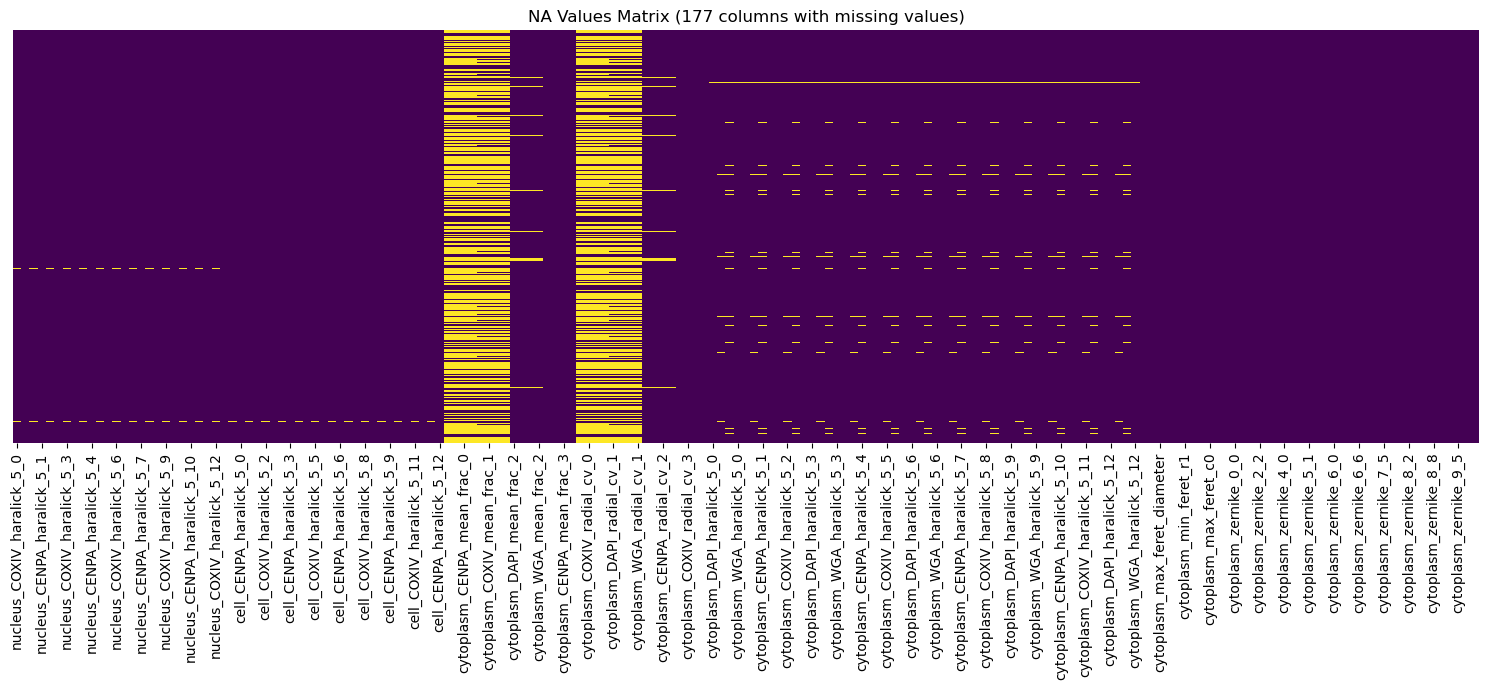

In [6]:
fig = visualize_nas(perturbation_filtered)
plt.show()

In [7]:
FEATURE_START_IDX = 17
DROP_COLS_THRESHOLD = 0.1

In [8]:
missing_values_filtered = missing_values_filter(
    perturbation_filtered, FEATURE_START_IDX, drop_cols_threshold=DROP_COLS_THRESHOLD
)

# Load channel names
channel_names = config["phenotype"]["channel_names"]
intensity_filtered = intensity_filter(
    perturbation_filtered, FEATURE_START_IDX, channel_names
)

intensity_filtered

Dropping 16 columns with ≥10.0% missing values
Imputing 161 columns with remaining missing values


,plate,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,...,cell_number_neighbors_1,cell_percent_touching_1,cell_first_neighbor_distance,cell_second_neighbor_distance,cell_angle_between_neighbors,cytoplasm_number_neighbors_1,cytoplasm_percent_touching_1,cytoplasm_first_neighbor_distance,cytoplasm_second_neighbor_distance,cytoplasm_angle_between_neighbors
0,1,A1,1502,501,1480.628283,1477.384343,354,277,100.674419,99.806202,...,0,0.000000,50.779623,74.421862,151.065981,0.0,0.000000,52.674577,70.256562,166.276907
1,1,A1,418,496,1476.375566,1478.313725,109,293,99.071429,99.107143,...,0,0.000000,47.622937,66.673654,164.933186,0.0,0.000000,47.218841,73.716465,172.741491
2,1,A1,1160,592,1480.918072,1475.887550,271,2036,670.875000,100.037500,...,0,0.000000,62.678918,63.863621,71.686607,0.0,0.000000,60.153852,68.126821,69.547069
3,1,A1,1185,543,1484.316222,1478.959617,300,230,101.153846,670.461538,...,0,0.000000,60.341099,60.813897,175.345937,0.0,0.000000,66.581960,67.210621,175.959281
4,1,A1,1448,547,1480.565083,1486.317149,351,1831,671.215385,103.030769,...,1,0.153846,39.735701,56.638368,71.506693,1.0,0.088496,39.549864,55.681246,79.132618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22520,1,A1,831,511,1312.816113,1699.527675,218,154,56.640777,723.864078,...,0,0.000000,65.559405,72.844730,55.674649,0.0,0.000000,56.393234,71.543513,131.394288
22521,1,A1,1017,451,1486.380638,1204.132013,257,200,100.471154,601.057692,...,0,0.000000,45.496332,89.098660,72.976404,0.0,0.000000,34.700716,83.190703,87.296246
22522,1,A1,193,366,1545.828172,1747.975025,38,269,116.857143,736.037594,...,0,0.000000,72.856111,78.369999,33.207179,0.0,0.000000,77.124473,77.180167,38.293143
22523,1,A1,1434,397,1250.568815,1633.331742,327,3453,1185.321839,140.068966,...,0,0.000000,66.324855,71.544292,151.676972,0.0,0.000000,64.961924,67.189967,145.825952


## <font color='red'>SET PARAMETERS</font>

### Prepare alignment data

- `BATCH_COLS`: Which columns of metadata have batch-specific information. Usually `["plate", "well"]`

In [9]:
BATCH_COLS = ["plate", "well"]

Number of components needed for 95.0% variance: 428
Shape of input data: (22753, 1651)
Shape of PCA transformed and reduced data: (22753, 428)
Top 10 pertubration counts:


gene_symbol_0
nontargeting    523
DCAF13           22
KLF5             22
LMAN2            21
ARPC4-TTLL3      21
ZNF286B          21
PHB              21
IREB2            21
RSL24D1          20
GOSR2            20
Name: count, dtype: Int64

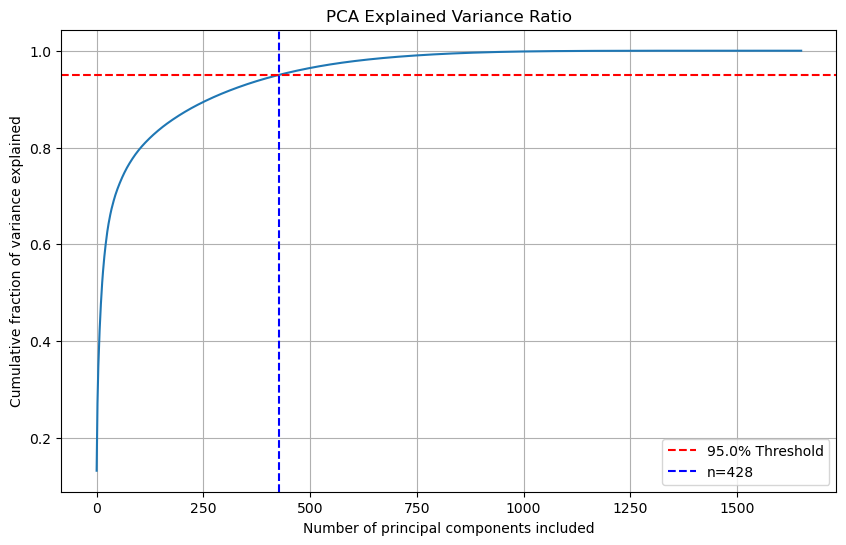

In [10]:
features, metadata = prepare_alignment_data(missing_values_filtered, BATCH_COLS, FEATURE_START_IDX)

pca_df_threshold, n_components, pca, fig = pca_variance_plot(features, variance_threshold=0.95)

print("Top 10 pertubration counts:")
metadata[PERTURBATION_NAME_COL].value_counts()[:10]

## <font color='red'>SET PARAMETERS</font>

### Prepare alignment data

- `PC_COUNT`: Number of principal components to use when creating embeddings with PCA (see figure above). Usually the amount of principal components needed to explain 95% of variance (see above).
- `CONTROL_KEY`: Name of perturbation in `PERTURBATION_NAME_COL` that indicates a control cell.

In [14]:
PC_COUNT = 428
CONTROL_KEY = "nontargeting"

In [ ]:
pca_embeddings = embed_by_pca(features.values, metadata, variance_or_ncomp=PC_COUNT, batch_col="batch_values")
tvn_normalized = tvn_on_controls(pca_embeddings, metadata, PERTURBATION_NAME_COL, CONTROL_KEY, "batch_values")

tvn_normalized_columns = [f'PCA_{i}' for i in range(tvn_normalized.shape[1])]
tvn_normalized_df = pd.DataFrame(tvn_normalized, index=metadata.index, columns=tvn_normalized_columns)
aligned_cell_data = pd.concat([metadata, tvn_normalized_df], axis=1)

aligned_cell_data

## Add aggregate parameters to config file

In [13]:
# # Add aggregate section
# config["aggregate"] = {
#     "perturbation_name_col": PERTURBATION_NAME_COL,
#     "perturbation_multi_col": PERTURBATION_MULTI_COL,
#     "filter_single_pert": FILTER_SINGLE_PERT,
#     "feature_start_idx": FEATURE_START_IDX,
#     "drop_cols_threshold": DROP_COLS_THRESHOLD,
#     "batch_cols": BATCH_COLS,
#     "pc_count": PC_COUNT,
#     "control_key": CONTROL_KEY,
# }

# # Write the updated configuration
# with open(CONFIG_FILE_PATH, "w") as config_file:
#     # Write the introductory comments
#     config_file.write(CONFIG_FILE_HEADER)

#     # Dump the updated YAML structure, keeping markdown comments for sections
#     yaml.dump(config, config_file, default_flow_style=False)